# EDS-TEM quantification of core shell nanoparticles

Using machine learning methods, such as independent component analysis (ICA), the composition of embedded nanostructures, such as core-shell nanoparticles, can be accurately measured as demonstrated by D. Roussow et al., Nano Letters, 2015 (see the [full article](https://www.repository.cam.ac.uk/bitstream/handle/1810/248102/Roussouw%20et%20al%202015%20Nano%20Letters.pdf?sequence=1)). Using the same data, this notebook reproduces the main results of this article.

For more assistance, please visit the [EDS Analysis](http://hyperspy.org/hyperspy-doc/current/user_guide/eds.html) section of the HyperSpy User Guide. In particular, the [EDS Quantification](http://hyperspy.org/hyperspy-doc/current/user_guide/eds.html#eds-quantification) portion of that page provides many more details about the quantification routines used in HyperSpy.


## Author

* 13/04/2015 Pierre Burdet - Developed for HyperSpy workshop at University of Cambridge

## Changes

* 29/05/2016 Duncan Johnstone. Update the syntax for HyperSpy 0.8.5 (Python 3 compatibility)
* 03/08/2016 Francisco de la Peña. Update the syntax for HyperSpy 1.1
* 06/08/2016 Francisco de la Peña. Update the syntax for HyperSpy 0.8.1
* 27/08/2016 Pierre Burdet. Update for workshop at EMC Lyon
* 04/04/2018 Joshua Taillon. Bugfix and update for workshop at NIST
* 18/07/2019 Katherine MacArthur. Update to include basic quantification, for M&M 2019 Portland
* 30/07/2021 Joshua Taillon. Minor updates for M&M 2021 Short Course (Virtual)

## Requirements

* HyperSpy 1.5.1

## <a id='top'></a> Contents

1. <a href='dat'> Specimen & Data</a>
2. <a href='#loa'> Loading and viewing data</a>
3. <a href='#counts'> Extracting Counts </a>
4. <a href='#quant'> Basic Quantification </a>
5. <a href='#bss'> Blind source separation of core/shell nanoparticles</a>
6. <a href='#bare'> Representative spectrum from bare cores</a>
7. <a href='#com'> Comparison and quantification</a>
8. <a href='#fur'> Going father: Isolating the nanoparticles</a>

# <a id='dat'></a> 1. Specimen & Data

The sample and the data used in this tutorial are described in 
D. Roussow, et al., Nano Letters, In Press (2015) (see the [full article](https://www.repository.cam.ac.uk/bitstream/handle/1810/248102/Roussouw%20et%20al%202015%20Nano%20Letters.pdf?sequence=1)).

FePt@Fe$_3$O$_4$ core-shell nanoparticles are investigated with an EDS/TEM experiment (FEI Osiris TEM, 4 EDS detectors). The composition of the core can be measured with ICA (see figure 1c). To prove the accuracy of the results, measurements on bare FePt bimetallic nanoparticles from a synthesis prior to the shell addition step are used.

<img src="images/core_shell.png" style="height:350px;">
Figure 1: (a) A spectrum image obtained from a cluster of core-shell nanoparticles. (b) The nanoparticles are comprised of a bi-metallic Pt/Fe core surrounded by an iron oxide shell on a carbon support. (c) ICA decomposes the mixed EDX signals into components representing the core (IC#0), shell (IC#1) and support (IC#2).

# <a id='loa'></a> 2. Loading and viewing data

<a href='#top'> Table of contents</a>

Import HyperSpy, numpy and matplotlib libraries.

*Remember, if at any point you do not understand how a function operates, its help file can be loaded by typing the name of the command followed by a '?' into a cell and then running that cell.*

In [1]:
# import the matplotlib backend and hyperspy
%matplotlib notebook
import hyperspy.api as hs

Load the spectrum images of the bare nanoparticles and those with a core-shell structure.

In [2]:
# load the data for this tutorial
c = hs.load("bare_core.hdf5")
cs = hs.load("core_shell.hdf5")

Check the metadata has imported correctly. In particular whether the list of elements you wish to analyse is correct.

In [3]:
# inspect the metadata for the loaded data
cs.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 35.0
│       │       └── energy_resolution_MnKa = 130.0
│       ├── Stage
│       │   └── tilt_alpha = 0.0
│       ├── acquisition_mode = STEM
│       ├── beam_energy = 200.0
│       └── microscope = Microscope TecnaiOsiris 200 kV D658 AnalyticalTwin
├── General
│   ├── date = 14.10.2014
│   └── title = Core shell
├── Sample
│   ├── elements = array(['Fe', 'Pt'], dtype='<U2')
│   └── xray_lines = array(['Fe_Ka', 'Pt_La'], dtype='<U5')
└── Signal
    ├── binned = True
    ├── signal_origin = 
    └── signal_type = EDS_TEM

Plot the core-shell data to inspect the signal level:

<IPython.core.display.Javascript object>


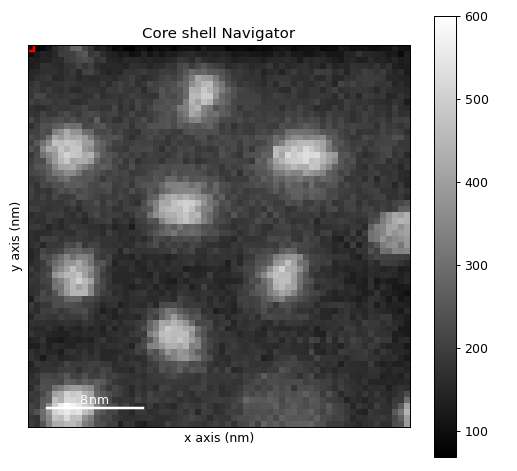

<IPython.core.display.Javascript object>


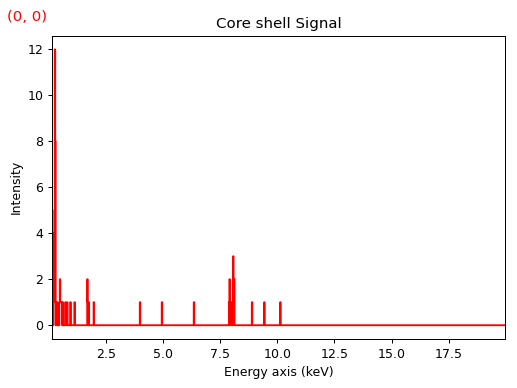

In [4]:
# plot the core-shell data
cs.plot()

Plotting the integrated counts for the whole spectrum image is a good way to check what elements exist in the sample. Adding 'True' to the function also labels any elements from the metadata onto the spectrum.

<IPython.core.display.Javascript object>


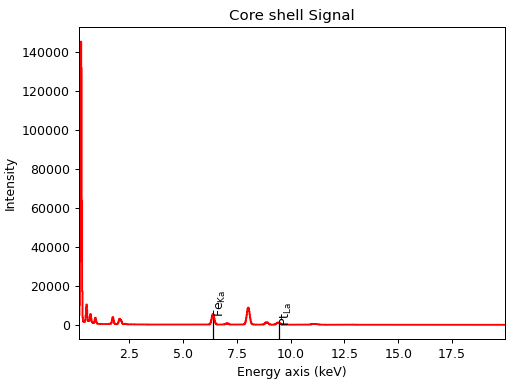

In [5]:
# inspect a sum spectrum
cs.sum().plot(True)

## <a id='#counts'></a> 3. Extracting count maps of elements

<a href='#top'> Table of contents</a>


If they're not already added it is important to make sure all the elements you want to extract the intensities for are in the metadata of the sample.

In [6]:
# set the correct elements and x-ray lines in each signal

cs.set_elements(['Fe','Pt'])
cs.set_lines(['Fe_Ka', 'Pt_La'])

c.set_elements(['Fe','Pt'])
c.set_lines(['Fe_Ka', 'Pt_La'])
#cs.add_elements and cs.add_lines also work if you don't want to override what is 
#already in the metadata.

Extracting lines can be done without any background or integration window parameters. However if none are specified the default integration window is 1 FWHM and no background subtraction is carried out.

Line_width is the distance from the x-ray line (in FWHM) the the background window is taken [left, right] allowing different distances for the two directions.
An asymmetric value is used here because otherwise the Pt background windows overlap with the Cu K$_β$ line from the sample grid.

In [7]:
# estimate background and integration windows
bw = cs.estimate_background_windows(line_width=[5.0, 2.0])
iw =  cs.estimate_integration_windows(windows_width=3)

It is important to plot the windows to check that they are selecting the data correctly otherwise errors, particularly in background subtraction arise.

The integration windows are represented by dashed lines and background windows by solid lines. The estimated background is the plotted by the close to horizontal black lines.

<IPython.core.display.Javascript object>


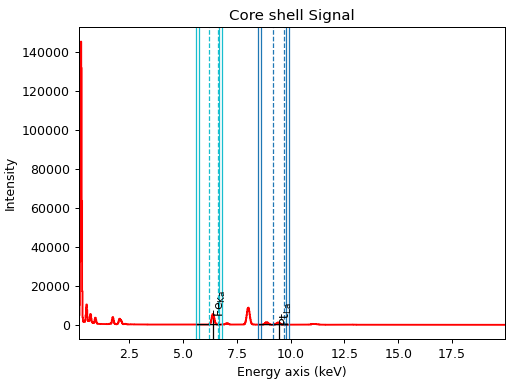

In [8]:
# inspect the windows
cs.sum().plot(True, background_windows=bw, integration_windows=iw)

*Try running the previous two cells of code  above with line_width=[3.0,3.0] and see how this results in an erroneous, background subtraction by plotting the background lines. (You might need to zoom in to see it)*

How accurate background subtraction will be on a pixel-by-pixel basis can be see with this plot. 

The x and y sliders select a pixel in the particle images we plotted earlier. 

You should be able to find some examples (e.g. the Fe K$_α$ line at X=39, Y=44) of where the background subtraction still fails due to a poor signal-to-noise ratio in the data.



<IPython.core.display.Javascript object>


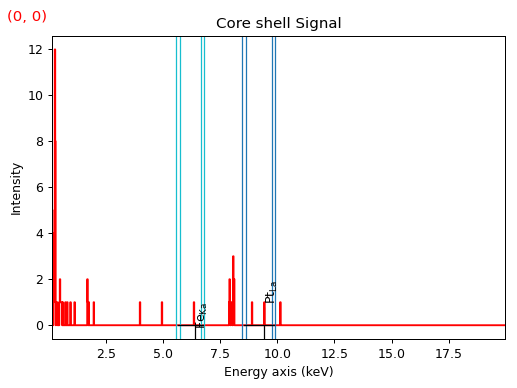

In [9]:
# plot the core-shell signal, showing the background calculation windows
cs.plot(True, background_windows=bw, navigator='slider')

Another way to adjust the location of the background windows is by changing specific numbers in the background window array individually.

Running the 'bw' command will output the array, which contains keV coordinates corresponding to the position of the background windows. Each row corresponds to a different element in the list given in the metadata. Remember arrays in Python start at (0,0).

In [10]:
# view the actual background window boundaries
bw

array([[5.59527895, 5.73004913, 6.67344035, 6.80821052],
       [8.47913271, 8.63962726, 9.7630891 , 9.92358364]])

These two commands therefore alter the position of the start and end points of the left-hand background window for Pt.

In [11]:
# fine-tune the background window boundaries
bw[1, 0] = 8.44
bw[1, 1] = 8.65
bw

array([[5.59527895, 5.73004913, 6.67344035, 6.80821052],
       [8.44      , 8.65      , 9.7630891 , 9.92358364]])

Often it is prudent to rebin the data such that counts per pixel are increased and a more reliable background subtraction can be carried out. This can be easily done with the rebin function to any new scale.

These functions will perform rebinning on both the core-shell ('cs') data and the core-only ('c') data. We define using the 'scale' parameter that we want 2x binning in X, 2x binning in Y, and 1x binning in Z (our counts).

*Note, as we are re-defining 'cs' or 'c', this overwrites our previously-imported data. This means running this command multiple times will re-bin the data multiple times. If you accidentally run this command too many times, simply re-import the data by running the 'hs.load' commands at the top of this workbook'.*

In [12]:
# rebin the data (don't run this cell more than once unless you want to keep rebinning!)
cs = cs.rebin(scale=(2,2,1))
c = c.rebin(scale=(2,2,1))

Finally, once the background subtraction windows have been selected to be in careful positions it is possible to extract the intensities. 

Note that exactly the same windows have been used for analysis of both the 'core' and 'core-shell' data sets. This is critical here as we are comparing the two datasets.

In [13]:
# do the background subtraction and line integration
cs_intensities = cs.get_lines_intensity(background_windows=bw, integration_windows=iw)
c_intensities = c.get_lines_intensity(background_windows=bw, integration_windows=iw)

Each 'get_lines_intensity' command will create a list of images, again in the same order of the list of elements in the list of metadata. If the element is not in the metadata its intensity map will not be extracted.

We can then run 'cs_intensities' to confirm the that we have extracted intensity maps for all our elements of interest.

In [14]:
# view the output of the get_lines_intensity method
cs_intensities

[<BaseSignal, title: X-ray line intensity of Core shell: Fe_Ka at 6.40 keV, dimensions: (32, 32|)>,
 <BaseSignal, title: X-ray line intensity of Core shell: Pt_La at 9.44 keV, dimensions: (32, 32|)>]

<IPython.core.display.Javascript object>


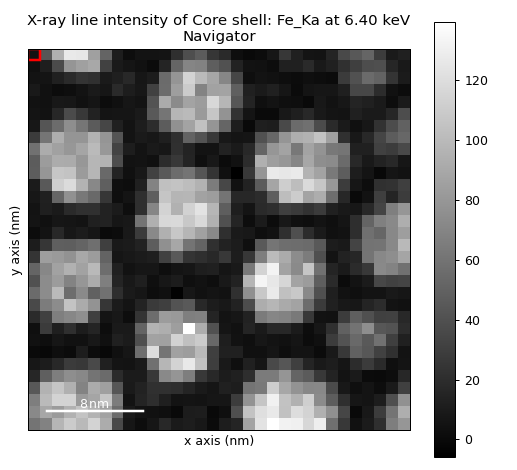

In [15]:
# Plotting one particular image (in this case, the first, Fe_Ka map) can be done with:
cs_intensities[0].plot()

<IPython.core.display.Javascript object>


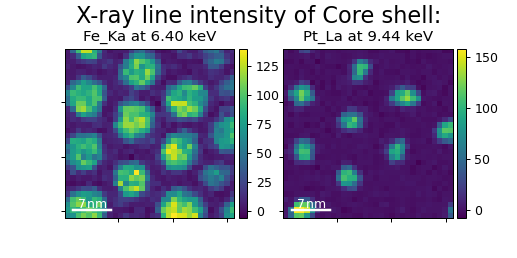

[<AxesSubplot:title={'center':'Fe_Ka at 6.40 keV'}>,
 <AxesSubplot:title={'center':'Pt_La at 9.44 keV'}>]

In [16]:
#All the intensity maps can be plotted using:
hs.plot.plot_images(cs_intensities, cmap='viridis', axes_decor=None, scalebar='all')

Plotting and extracting intensity for both data sets can be condensed into one line.

<IPython.core.display.Javascript object>


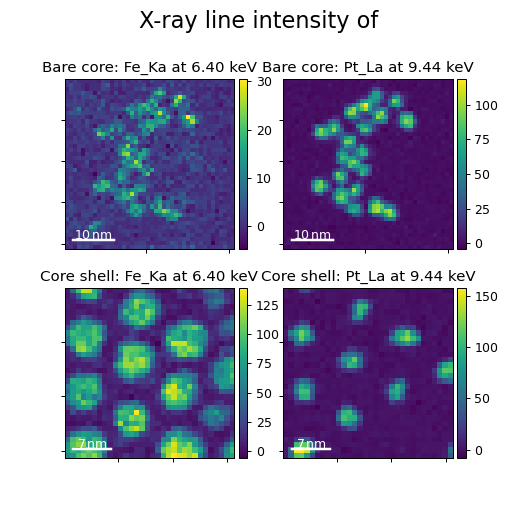

In [17]:
# plot and extract intensity data for both datasets in one command
# (this is an example of how once you have a workflow, scripting can make your routine
# analyses much easier...)
axes = hs.plot.plot_images((c.get_lines_intensity(background_windows=bw, integration_windows=iw)
                                          + cs.get_lines_intensity(background_windows=bw, integration_windows=iw)),
                           scalebar='all', axes_decor=None, per_row=2, cmap='viridis')

## <a id='#quant'></a> 4. Quantification of count maps

<a href='#top'> Table of contents</a>

Hyperspy is able to carry out EDX quantification using k-factors (`"CL"`), $\zeta$-factors (`"zeta"`), or cross_sections (`"cross_sections"`). 

All these methods are applied in the same way using the combination of the stack of intensities and and original data.

For `"zeta"` or `"cross_section"` quantification, it is very important that both an accurate `"live_time"` and a `"beam_current"` should be present in the metadata.

In [18]:
#Setting these parameters in the metadata.
cs.set_microscope_parameters(live_time = 6.15) #in seconds
cs.set_microscope_parameters(beam_current = 0.5) #in nA

In [19]:
#From Bruker software (Esprit) k-factors
factors = [1.450226, 5.75602]

In [20]:
# perform K-factor (Cliff-Lorimer or "thin-film") quantification
quant = cs.quantification(cs_intensities, 'CL', factors=factors)

[########################################] | 100% Completed |  0.1s


/home/jat/.conda/envs/hyperspy/lib/python3.8/site-packages/hyperspy/misc/material.py:61: RuntimeWarning: invalid value encountered in true_divide
  atomic_percent[i] /= sum_weight


In [21]:
# view output type of the quantification method
quant

[<BaseSignal, title: atomic percent of Fe, dimensions: (32, 32|)>,
 <BaseSignal, title: atomic percent of Pt, dimensions: (32, 32|)>]

Again as with the intensities the quantification function result produces a list of images with atomic percent of each element (at least in the `"CL"` case). 

In the `"zeta"` and `"cross_section"` methods more information is outputted from quantification. See the [EDS quantification](http://hyperspy.org/hyperspy-doc/current/user_guide/eds.html#eds-quantification) section of the documentation for more details.

Alternatively, if the factors are treated as `"cross_sections"` then the output result contains two lists of images, the first is a list of atomic *percent* maps (Index `[0]`) the second is a list of atomic *number* maps (Index `[1]`). This allows us to easily "zero-out" regions of the image with too few counts.

*Please note these values aren't accurate cross-sections but can be used as such for the purpose of this demo.*

Ignore the warning produced, in this case we want to use a 1nm$^2$ probe size. As long as the pixel scale is calibrated in your spectrum image, probe size is taken as the pixel unless otherwise specified using `s.set_microscope_parameters(probe_area = ?)`.

In [22]:
# quantify using the "cross_section" method
quant = cs.quantification(cs_intensities, 'cross_section', factors=factors)

/home/jat/.conda/envs/hyperspy/lib/python3.8/site-packages/hyperspy/_signals/eds_tem.py:807: UserWarning: Please note that the probe area has been calculated to be 1 nm², meaning that it is highly likley that the scale of the navigation axes have not been set correctly. Please read the user guide for how to set this.
  warnings.warn("Please note that the probe area has been "
/home/jat/.conda/envs/hyperspy/lib/python3.8/site-packages/hyperspy/misc/eds/utils.py:627: RuntimeWarning: invalid value encountered in true_divide
  composition = number_of_atoms / total_atoms


In [23]:
# view output type of the "cross-section" method
quant

([<BaseSignal, title: atomic percent of Fe, dimensions: (32, 32|)>,
  <BaseSignal, title: atomic percent of Pt, dimensions: (32, 32|)>],
 [<BaseSignal, title: atom counts of Fe, dimensions: (32, 32|)>,
  <BaseSignal, title: atom counts of Pt, dimensions: (32, 32|)>])

Summing all the images containing numbers of atoms (quant[1]) gives us an image mapping out the total number of estimated atoms in the sample.

<IPython.core.display.Javascript object>


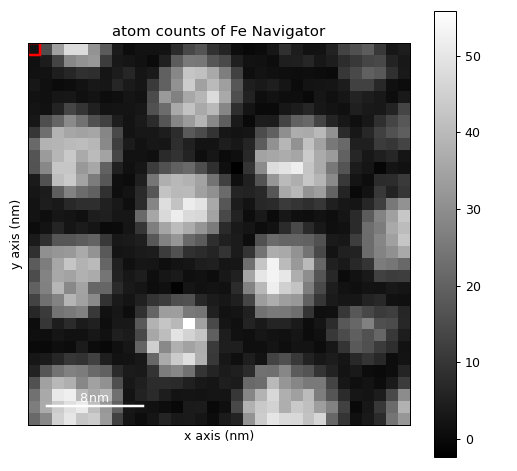

In [24]:
# calculate the number of atoms in the dataset from the cross sections
No_of_atoms = quant[1][0] + quant[1][1]
No_of_atoms.plot()

This 'total number of atoms' image can be used to make a mask and 'zero-out' any region of the image where the total counts equate to less than 1 atom count. This could also be done on an element by element basis instead.

<IPython.core.display.Javascript object>


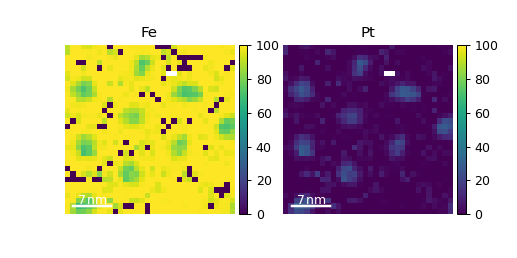

[<AxesSubplot:title={'center':'Fe'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <AxesSubplot:title={'center':'Pt'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

In [25]:
# calculate a mask where the number of atoms is > 1
Mask = No_of_atoms > 1.

# apply the mask to the atomic percentage data and plot the results
hs.plot.plot_images([Mask*quant[0][0], Mask*quant[0][1]], scalebar ='all', cmap='viridis',
                   label=['Fe', 'Pt'], axes_decor='off', vmin=0, vmax=100)

## <a id='bss'></a> 5. Blind source separation of core/shell nanoparticles

<a href='#top'> Table of contents</a>

Another often useful way to analyze EDS data (both TEM and SEM) is to apply signal separation techniques to extract phase or physical separation information about the sample. Compared to quantification (as above), this technique often serves to provide qualitative information about sample composition and to better visualize what elements are correlated together spatially (perhaps in a unique phase). The outputs of these can be further quantified, if desired (although this technique may not be completely rigorous and may discard data, potentially).

We start by applying blind source separation to obtain a factor (spectrum) corresponding to the core:

In [26]:
# matrix methods only work on "float" data (not integers), so convert data type
# (note this may be expensive in terms of memory on a larger spectrum image)
cs.change_dtype('float')

In [27]:
# apply PCA decomposition to inspect dimensionality
cs.decomposition()

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


<IPython.core.display.Javascript object>


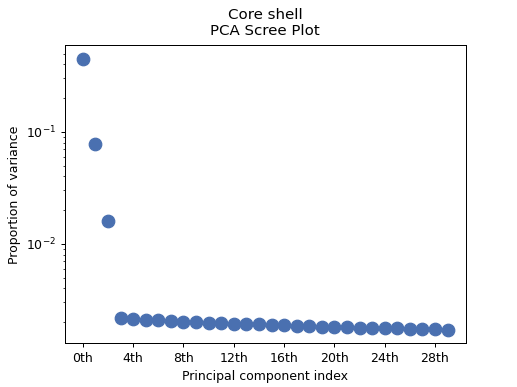

In [28]:
# examine the Scree plot
ax = cs.plot_explained_variance_ratio()

Use the FastICA algorithm to rotate the data for maximal independence between the first three components:

In [29]:
# use blind_source_separation on three components
cs.blind_source_separation(3)

[########################################] | 100% Completed |  0.1s


Blind source separation info:
  number_of_components=3
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-10, whiten=False)


<IPython.core.display.Javascript object>


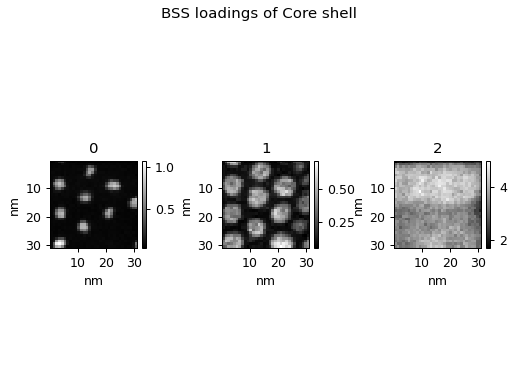

In [30]:
# plot loading maps (i.e. component intensities)
axes = cs.plot_bss_loadings()

<IPython.core.display.Javascript object>


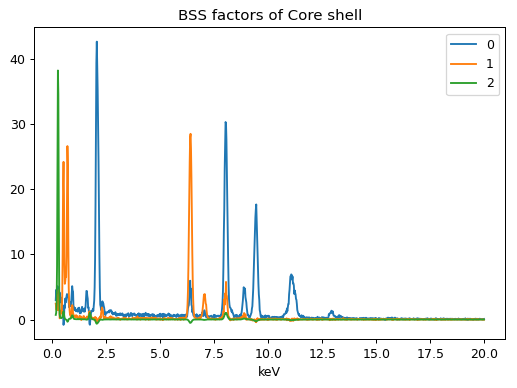

In [31]:
# plot factors (i.e. component spectra)
axes = cs.plot_bss_factors()

The first component corresponds to the core.

In [32]:
# extract first component into a variable for later use
s_bss = cs.get_bss_factors().inav[0]

## <a id='bare'></a> 6. Representative spectrum from bare cores

<a href='#top'> Table of contents</a>

Since we also have data from the "bare cores" (i.e. without a shell), we can obtain an integrated representative spectrum of the bare nanoparticles. To do so more accurately, the low intensity of Pt L$_{\alpha}$ is masked:

In [33]:
# get x-ray line intensity for the Pt L-alpha line
pt_la = c.get_lines_intensity(['Pt_La'])[0]

<IPython.core.display.Javascript object>


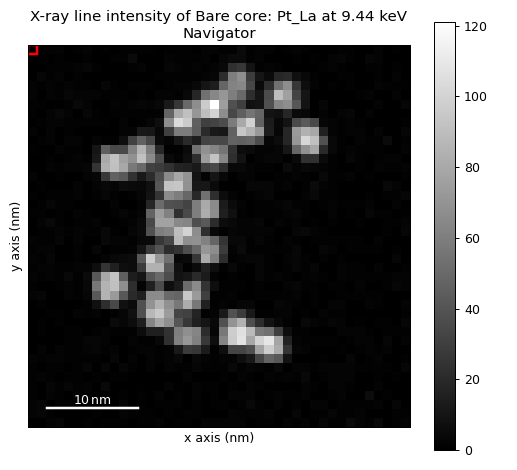

In [34]:
# plot the intensity and inspect the counts to find a good cutoff value
pt_la.plot()

In [35]:
# calculate a mask based off a reasonable threshold
mask = pt_la > 12

In [36]:
# convert mask to numeric type for easier processing
mask.change_dtype('int')

<IPython.core.display.Javascript object>


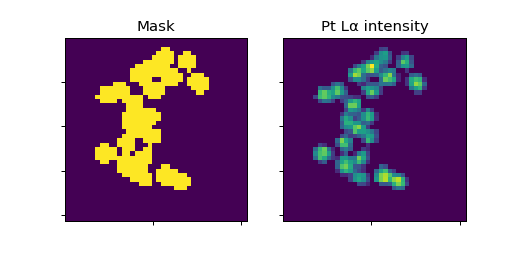

In [37]:
# plot both the mask, and the masked data to compare
# (explicitly set contrast limits to avoid small bug with numpy and booleans)
axes = hs.plot.plot_images([mask, pt_la * mask], axes_decor=None, colorbar=None,
                           label=['Mask', 'Pt Lα intensity'], cmap='viridis')

Sum over the particles after masking to obtain a representative bare core spectrum:

In [38]:
# apply the mask and calculate the sum spectrum over the navigation dimensions
s_bare = (c * mask).sum()

## <a id='com'></a> 7. Model fitting and quantification

<a href='#top'> Table of contents</a>

With a greater signal to noise ratio from integrating the spectrum curve fitting now becomes possible as a method of intensity extraction. 

First we stack together the spectrum of bare particles and the first ICA component.

In [39]:
# change masked core data to float
s_bare.change_dtype('float')

In [40]:
# stack the masked core data and the BSS-extracted component
s = hs.stack([s_bare, s_bss], new_axis_name='Bare or BSS')

[########################################] | 100% Completed |  0.1s


In [41]:
# set the title of the new stacked signal
s.metadata.General.title = 'Bare or BSS'

<IPython.core.display.Javascript object>


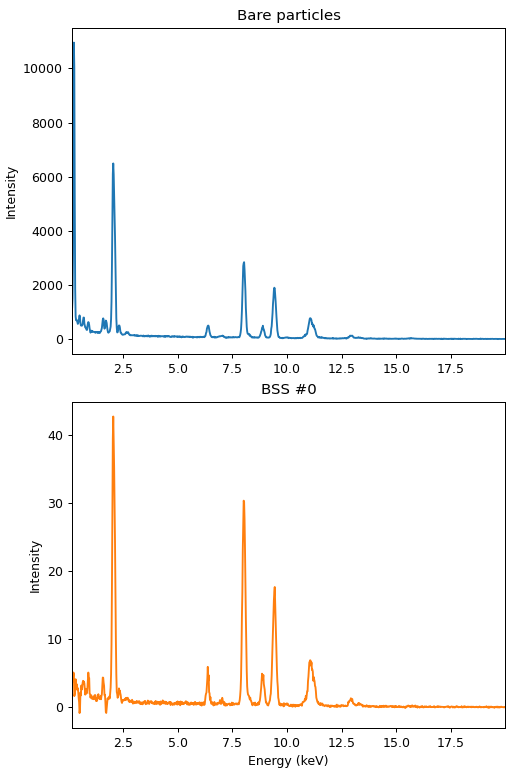

In [42]:
# plot the spectra together
axes = hs.plot.plot_spectra(s, style='mosaic', legend=['Bare particles', 'BSS #0'])

### Method 1 - Window extraction

X-ray intensities measurement with background subtraction, using the windows created earlier.

<IPython.core.display.Javascript object>


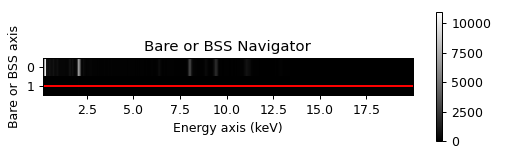

<IPython.core.display.Javascript object>


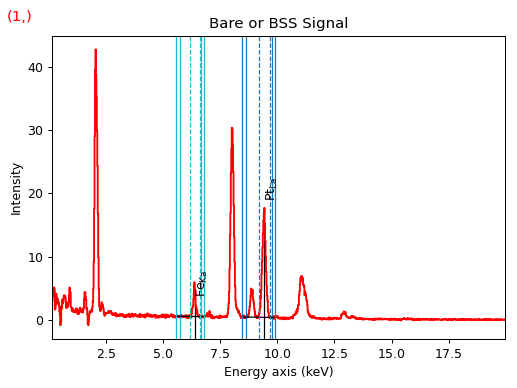

In [43]:
# plot both spectra with integration windows for comparison
s.plot(background_windows=bw, integration_windows=iw)

In [45]:
# extract line intensities from both summed spectra
sI = s.get_lines_intensity(background_windows=bw, integration_windows=iw)

In [46]:
# calcualte integrated line intensity ratios:
bare_ratio = list(sI[0].inav[0].data / sI[1].inav[0].data)[0]
bss_ratio = list(sI[0].inav[1].data / sI[1].inav[1].data)[0]

In [47]:
# compare the results between bare core masked data and bss component
print(f'Bare core Fe_Kα/Pt_Lα ratio: \t{bare_ratio:.2f}')
print(f'BSS Fe_Kα/Pt_Lα ratio: \t\t{bss_ratio:.2f}')

Bare core Fe_Kα/Pt_Lα ratio: 	0.19
BSS Fe_Kα/Pt_Lα ratio: 		0.18


### Method 2 - Model fitting

We can also measure X-ray intensity by fitting a Gaussian model

In [67]:
# Remove the low energy part of the spectrum as this is not a region we're interested in.
m = s.isig[5.:15.].create_model()

In [68]:
# Add lines not in our sample, but present in the data 

# These lines need to be added to the model because they are not in the metadata,
# and a model built without them would be inaccurate for the data contained in the signal
# In this way they are included in the curve fitting but not in the final quantification.

m.add_family_lines(['Cu_Ka', 'Co_Ka'])

In [69]:
# view all the model components
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |  background_order_6 |  background_order_6 |          Polynomial
   1 |               Fe_Ka |               Fe_Ka |            Gaussian
   2 |               Fe_Kb |               Fe_Kb |            Gaussian
   3 |               Pt_La |               Pt_La |            Gaussian
   4 |              Pt_Lb1 |              Pt_Lb1 |            Gaussian
   5 |              Pt_Lb4 |              Pt_Lb4 |            Gaussian
   6 |               Pt_Ln |               Pt_Ln |            Gaussian
   7 |               Pt_Ll |               Pt_Ll |            Gaussian
   8 |              Pt_Lb2 |              Pt_Lb2 |            Gaussian
   9 |              Pt_Lb3 |              Pt_Lb3 |            Gaussian
  10 |              Pt_Lg3 |              Pt_Lg3 |            Gaussian
  11 |              Pt_Lg1 |              Pt_Lg1 |            Gaussian
  12 |

<IPython.core.display.Javascript object>


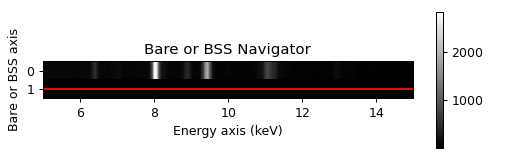

<IPython.core.display.Javascript object>


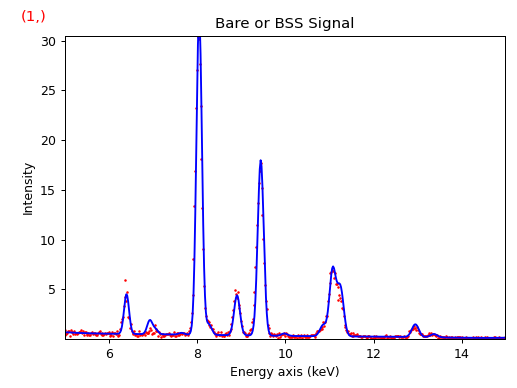

In [70]:
# plot the model
m.plot()

In [79]:
# perform model fitting on both spectra in the stack
m.multifit()

/home/jat/.conda/envs/hyperspy/lib/python3.8/site-packages/hyperspy/model.py:1580: VisibleDeprecationWarning: The 'iterpath' default will change from 'flyback' to 'serpentine' in HyperSpy version 2.0. Change 'iterpath' to other than None to suppress this warning.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

In [72]:
# fit the background component separately
m.fit_background()

In [73]:
# calibrate the energy axis resolution by fitting Gaussians to the peak widths
m.calibrate_energy_axis()

<IPython.core.display.Javascript object>


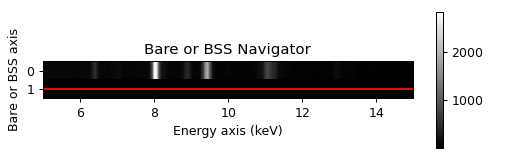

<IPython.core.display.Javascript object>


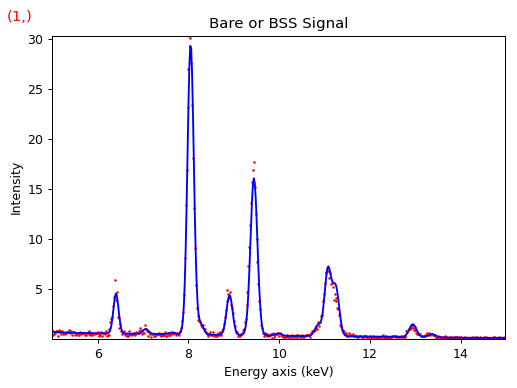

In [74]:
# plot the model once more for final inspection
m.plot()

In [80]:
# run get_lines_intensity again, but directly from the fitted model rather than the
# background-subtracted data

# pull out only the first two lines (Fe and Pt), since that's all we're interested in
sI = m.get_lines_intensity()[:2]
sI

[<BaseSignal, title: Intensity of Fe_Ka at 6.40 keV from Bare or BSS, dimensions: (2|)>,
 <BaseSignal, title: Intensity of Pt_La at 9.44 keV from Bare or BSS, dimensions: (2|)>]

Set up the kfactors for Fe K$_{\alpha}$ and Pt L$_{\alpha}$.

In [81]:
# From Bruker software (Esprit)
kfactors = [1.450226, 5.075602]

Quantify with Cliff Lorimer.

In [82]:
# perform k-factor quantification ("CL method")
composition = s.quantification(method="CL", intensities=sI, factors=kfactors)

[########################################] | 100% Completed |  0.1s


In [83]:
print('             |-----------------------------|')
print('             |     Atomic compositions     |')
print('             |-----------------------------|')

print(' \t     |  Bare core  |   BSS Signal  |')
print('|------------|-------------|---------------|')
print('| Fe (at. %) |    {:.2f}    |     {:.2f}     |'.format(composition[0].data[0], composition[0].data[1]))
print('| Pt (at. %) |    {:.2f}    |     {:.2f}     |'.format(composition[1].data[0], composition[1].data[1]))
print('|------------|-------------|---------------|')

             |-----------------------------|
             |     Atomic compositions     |
             |-----------------------------|
 	     |  Bare core  |   BSS Signal  |
|------------|-------------|---------------|
| Fe (at. %) |    16.64    |     15.95     |
| Pt (at. %) |    83.36    |     84.05     |
|------------|-------------|---------------|


As can be seen from the atomic percentage results, the quantification obtained from the BSS-separated signal of a core-shell dataset is nearly identical (within an 1% absolute difference) to that of data actually collected from bare cores. This indicates that BSS can be a reliable way to separate out the components, and a reliable analysis can be performed on the cores and shells separately without having to acquire another dataset (although that is of course still a good sanity-check).

This notebook has demonstrated a number of features available for processing EDS data in HyperSpy, including unsupervised machine learning, model fitting, quantification via different methods, and comparison to "control" data. Similar methods can be used on your own data, and with the tools provided in HyperSpy, you have the power to completely control your EDS analysis!

## <a id='fur'></a> 6. Going further (bonus section)

<a href='#top'> Table of contents</a>

This "bonus" section demonstrates how you can identify individual isolated particles from EDS data using other processing tools from [`scikit-image`](http://scikit-image.org/) and [`scipy`](http://www.scipy.org/). (another third-party library in the Scientific python ecosystem). With a few more commands, can you figure out how to get their average size? Perhaps also investigate how the mask level effects this calculation, or how you could better identify starting positions (seeds) for the watershed algorithm. The scripting capabilities of Python put these sorts of analyses within reach and (relatively) simple!

Steps to follow:

- Transform the mask into a distance map.
- Find local maxima.
- Apply the watershed to the distance map using the local maximum as seed (markers).

Adapted from this scikit-image [example](http://scikit-image.org/docs/dev/auto_examples/plot_watershed.html).

In [84]:
from scipy.ndimage import distance_transform_edt, label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [85]:
distance = distance_transform_edt(mask.data)
local_maxi = peak_local_max(distance, indices=False,
                            min_distance=2, labels=mask.data)
labels = watershed(-distance, markers=label(local_maxi)[0],
                   mask=mask.data)

<IPython.core.display.Javascript object>


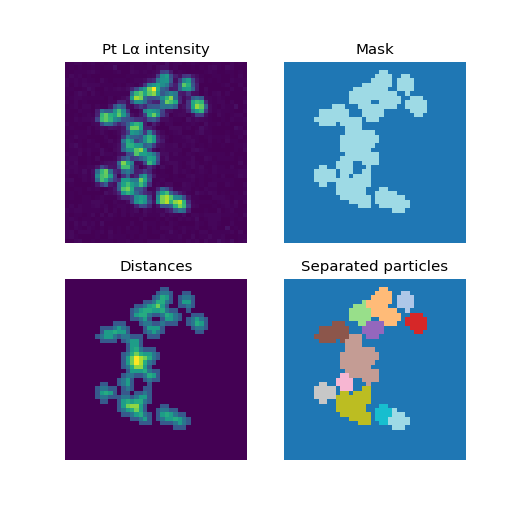

In [86]:
axes = hs.plot.plot_images(
    [pt_la.T, mask.T, hs.signals.Signal2D(distance), hs.signals.Signal2D(labels)],
    axes_decor='off', per_row=2, colorbar=None, cmap=['viridis','tab20'],
    label=['Pt Lα intensity', 'Mask',
           'Distances', 'Separated particles'])